In [21]:
import numpy as np
import cv2
from math import pi, cos, sin, tan, atan, sqrt, ceil, floor
import time
import random
import sys
import matplotlib.pyplot as plt


class FishEyeGenerator:

    # dst_shape format: [rows, cols]
    def __init__(self, focal_len, dst_shape):

        self._focal_len = focal_len
        # 输出的鱼眼图像的行和列大小
        self._shape = dst_shape
        self._ratio = min(self._shape[0], self._shape[1]) / (self._focal_len * pi)

        mask = np.ones([self._shape[0], self._shape[1]], dtype=np.uint8)
        square_r = (min(self._shape[0],self._shape[1])/2)**2
        for i in range(self._shape[0]):
            for j in range(self._shape[1]):
                if ((i-self._shape[0]/2)**2+(j-self._shape[1]/2)**2) >= square_r:
                    mask[i,j] = 0
        mask = np.array(mask)
        mask = mask.reshape(-1)
        self._bad_index = (mask==0)

        self._PARAM = 500
        self._init_ext_params()

        self._bkg_color = [0, 0 ,0]
        self._bkg_label = 20

        

    def set_bkg(self, bkg_label=20, bkg_color=[0,0,0]):
        self._bkg_color = list(bkg_color)
        self._bkg_label = bkg_label



    def _init_ext_params(self):
        self.ALPHA_RANGE = [0, 0]
        self.BETA_RANGE = [0, 0]
        self.THETA_RANGE = [0, 0]

        self.XTRANS_RANGE = [-self._shape[1] / 2, self._shape[1] / 2]
        self.YTRANS_RANGE = [-self._shape[0] / 2, self._shape[0] / 2]
        self.ZTRANS_RANGE = [-0.6*self._PARAM, 0.6*self._PARAM]

        self._alpha = 0
        self._beta = 0
        self._theta = 0
        self._x_trans = 0
        self._y_trans = 0
        self._z_trans = 0

    def set_ext_param_range(self,ext_param_range):
        '''
        extParam[0]~[2] 角度制的旋转角
        extParam[3]~[4] x轴和y轴的平移，建议在[0,0.6]
        extParam[5] z轴的位移范围建议在[0,0.6]
        :param extParam: a list with 6 float
        :return: void
        '''
        self.ALPHA_RANGE = [-ext_param_range[0]*pi/180, ext_param_range[0]*pi/180]
        self.BETA_RANGE = [-ext_param_range[1]*pi/180, ext_param_range[1]*pi/180]
        self.THETA_RANGE = [-ext_param_range[2]*pi/180, ext_param_range[2]*pi/180]

        self.XTRANS_RANGE = [-self._shape[1]*ext_param_range[3], self._shape[1]*ext_param_range[3]]
        self.YTRANS_RANGE = [-self._shape[0]*ext_param_range[4], self._shape[0]*ext_param_range[4]]
        self.ZTRANS_RANGE = [-ext_param_range[5] * self._PARAM, ext_param_range[5] * self._PARAM]


    def _init_ext_matrix(self):
        self._rotate_trans_matrix = \
            np.array([
                [cos(self._beta) * cos(self._theta), cos(self._beta) * sin(self._theta), -sin(self._beta),
                 self._x_trans],
                [-cos(self._alpha) * sin(self._theta) + sin(self._alpha) * sin(self._beta) * cos(self._theta),
                 cos(self._alpha) * cos(self._theta) + sin(self._alpha) * sin(self._beta) * sin(self._theta),
                 sin(self._alpha) * cos(self._beta), self._y_trans],
                [sin(self._alpha) * sin(self._theta) + cos(self._alpha) * sin(self._beta) * cos(self._theta),
                 -sin(self._alpha) * cos(self._theta) + cos(self._alpha) * sin(self._beta) * sin(self._theta),
                 cos(self._alpha) * cos(self._beta), self._z_trans],
                [0, 0, 0, 1]
            ])

    def set_f(self, focal_len):
        self._focal_len = focal_len
        self._ratio = min(self._shape[0],self._shape[1])/(self._focal_len*pi)


    def rand_f(self, f_range=[200,400]):
        temp = random.random()
        self._focal_len = f_range[0]*(1-temp)+f_range[1]*temp
        self._ratio = min(self._shape[0],self._shape[1])/(self._focal_len*pi)
        # print("focal len", self._focal_len)


    def _init_pin_matrix(self, src_shape):
        rows = src_shape[0]
        cols = src_shape[1]
        self._pin_matrix = \
            np.array([
                [self._PARAM, 0, cols/2, 0],
                [0, self._PARAM, rows/2, 0],
                [0, 0, 1, 0]
            ])


    def print_ext_param(self):
        print("alpha:", self._alpha*180/pi, "度")
        print("beta:", self._beta*180/pi, "度")
        print("theta:", self._theta*180/pi, "度")

        print("X轴平移量：",self._x_trans)
        print("Y轴平移量：",self._y_trans)
        print("Z轴平移量：",self._z_trans)


    def set_ext_params(self, extParam):
        '''
        extParam[0]~[2] 角度制的旋转角
        extParam[3]~[4] x轴和y轴的平移，建议在[-0.6,0.6]
        extParam[5] z轴的位移范围建议在[-0.6,0.6]
        :param extParam: a list with 6 float
        :return: void
        '''
        self._alpha = extParam[0]*pi/180
        self._beta = extParam[1]*pi/180
        self._theta = extParam[2]*pi/180

        self._x_trans = extParam[3]*self._shape[1]
        self._y_trans = extParam[4]*self._shape[0]
        self._z_trans = extParam[5]*self._PARAM


    def rand_ext_params(self):
        temp = random.random()
        self._alpha = self.ALPHA_RANGE[0]*(1-temp) + self.ALPHA_RANGE[1]*temp
        temp = random.random()
        self._beta = self.BETA_RANGE[0]*(1-temp) + self.BETA_RANGE[1]*temp
        temp = random.random()
        self._theta = self.THETA_RANGE[0]*(1-temp) + self.THETA_RANGE[1]*temp

        temp = random.random()
        self._x_trans = self.XTRANS_RANGE[0] * (1 - temp) + self.XTRANS_RANGE[1] * temp
        temp = random.random()
        self._y_trans = self.YTRANS_RANGE[0] * (1 - temp) + self.YTRANS_RANGE[1] * temp
        temp = random.random()
        self._z_trans = self.ZTRANS_RANGE[0] * (1 - temp) + self.ZTRANS_RANGE[1] * temp


    def _calc_cord_map(self, cv_img):
        self._init_ext_matrix()
        self._init_pin_matrix(cv_img.shape)

        src_rows = cv_img.shape[0]
        src_cols = cv_img.shape[1]
        dst_rows = self._shape[0]
        dst_cols = self._shape[1]

        # 生成坐标矩阵
        cord_x, cord_y = np.meshgrid(np.arange(dst_cols), np.arange(dst_rows))
        cord = np.dstack((cord_x, cord_y)).astype(float) - np.array([dst_cols / 2, dst_rows / 2], dtype=float)

        cord = cord.reshape(-1, 2)

        # shape=(dst_rows*dst_cols, 2)
        cord = np.array(cord) / self._ratio

        radius_array = np.sqrt(np.square(cord[:, 0]) + np.square(cord[:, 1]))
        theta_array = radius_array / self._focal_len

        new_x_array = np.tan(theta_array) * cord[:, 0] / radius_array * self._focal_len + 0.1
        new_y_array = np.tan(theta_array) * cord[:, 1] / radius_array * self._focal_len + 0.1

        temp_index1 = radius_array == 0
        temp_index2 = cord[:, 0] == 0
        temp_index3 = cord[:, 1] == 0
        bad_x_index = temp_index1 | (temp_index2 & temp_index1)
        bad_y_index = temp_index1 | (temp_index3 & temp_index1)

        new_x_array[bad_x_index] = 0
        new_y_array[bad_y_index] = 0

        new_x_array = new_x_array.reshape((-1, 1))
        new_y_array = new_y_array.reshape((-1, 1))

        new_cord = np.hstack((new_x_array, new_y_array))
        new_cord = np.hstack((new_cord, np.ones((dst_rows * dst_cols, 1)) * self._PARAM))
        new_cord = np.hstack((new_cord, np.ones((dst_rows * dst_cols, 1))))

        # shape=(pix_num, 4)
        pin_camera_array = np.matmul(self._rotate_trans_matrix, new_cord.T).T

        # shape=(pix_num, 3)
        pin_image_cords = np.matmul(self._pin_matrix, pin_camera_array.T).T

        self._map_cols = pin_image_cords[:, 0] / pin_image_cords[:, 2]
        self._map_rows = pin_image_cords[:, 1] / pin_image_cords[:, 2]

        self._map_cols = self._map_cols.round().astype(int)
        self._map_rows = self._map_rows.round().astype(int)

        index1 = self._map_rows < 0
        index2 = self._map_rows >= src_rows
        index3 = self._map_cols < 0
        index4 = self._map_cols >= src_cols
        index5 = pin_image_cords[:, 2] <= 0

        bad_index = index1 | index2 | index3 | index4 | index5
        bad_index = bad_index | self._bad_index
        self._map_cols[bad_index] = cv_img.shape[1]
        self._map_rows[bad_index] = 0


    def _extend_img_color(self, cv_img):
        dst_img = np.hstack((cv_img, np.zeros((cv_img.shape[0], 1, 3), dtype=np.uint8)))
        dst_img[0, cv_img.shape[1]] = self._bkg_color
        return dst_img

    def _extend_img_gray(self, cv_img):
        dst_img = np.hstack((cv_img, np.zeros((cv_img.shape[0], 1), dtype=np.uint8)))
        dst_img[0, cv_img.shape[1]] = self._bkg_label
        return dst_img

    def transFromColor(self, cv_img, reuse=False):
        if not reuse:
            self._calc_cord_map(cv_img)

        cv_img = self._extend_img_color(cv_img)
        dst = np.array(cv_img[(self._map_rows, self._map_cols)])
        dst = dst.reshape(self._shape[0], self._shape[1], 3)
        return dst


    def transFromGray(self, cv_img, reuse=False):
        if not reuse:
            self._calc_cord_map(cv_img)

        cv_img = self._extend_img_gray(cv_img)
        dst = np.array(cv_img[(self._map_rows, self._map_cols)])
        dst = dst.reshape(self._shape[0], self._shape[1])
        return dst


alpha: 0.0 度
beta: 0.0 度
theta: 0.0 度
X轴平移量： 0
Y轴平移量： 0
Z轴平移量： -500


C:\Users\EHmin\AppData\Local\Temp\ipykernel_7856\892698758.py:203: RuntimeWarning: divide by zero encountered in divide
  self._map_cols = pin_image_cords[:, 0] / pin_image_cords[:, 2]
C:\Users\EHmin\AppData\Local\Temp\ipykernel_7856\892698758.py:203: RuntimeWarning: invalid value encountered in divide
  self._map_cols = pin_image_cords[:, 0] / pin_image_cords[:, 2]
C:\Users\EHmin\AppData\Local\Temp\ipykernel_7856\892698758.py:204: RuntimeWarning: divide by zero encountered in divide
  self._map_rows = pin_image_cords[:, 1] / pin_image_cords[:, 2]
C:\Users\EHmin\AppData\Local\Temp\ipykernel_7856\892698758.py:204: RuntimeWarning: invalid value encountered in divide
  self._map_rows = pin_image_cords[:, 1] / pin_image_cords[:, 2]
C:\Users\EHmin\AppData\Local\Temp\ipykernel_7856\892698758.py:206: RuntimeWarning: invalid value encountered in cast
  self._map_cols = self._map_cols.round().astype(int)
C:\Users\EHmin\AppData\Local\Temp\ipykernel_7856\892698758.py:207: RuntimeWarning: invalid 

0.5720181465148926


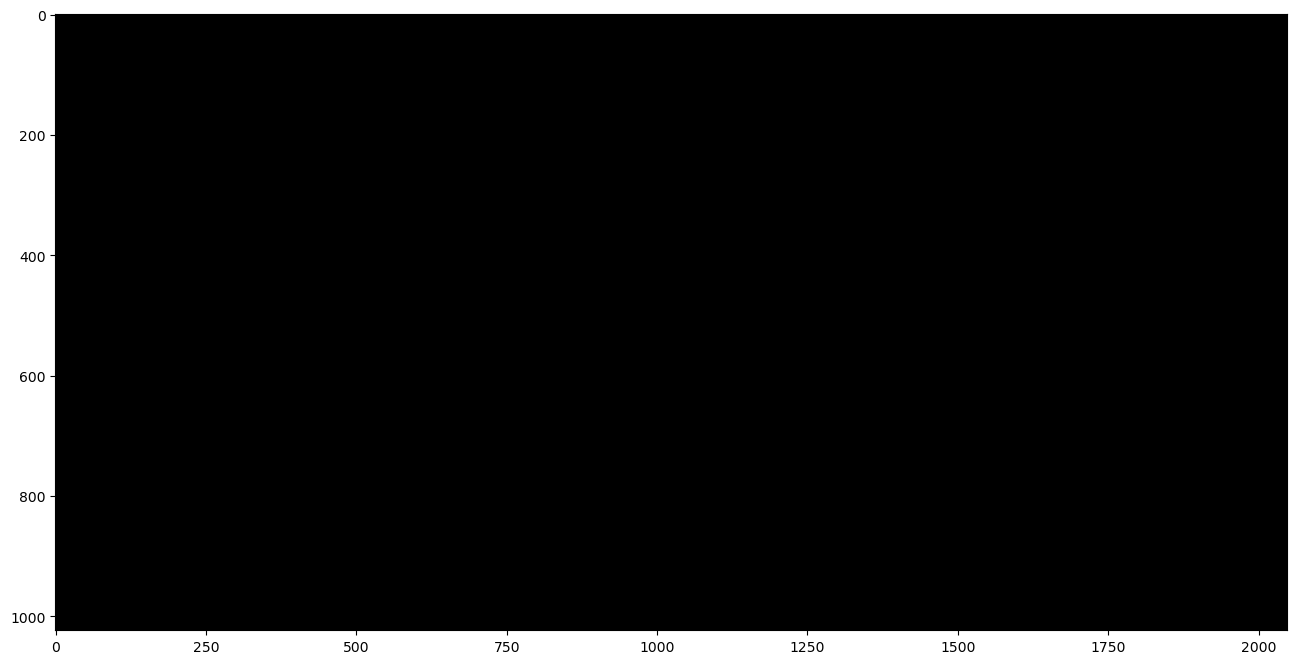

In [26]:
def test_color():
    trans = FishEyeGenerator(300, [1024,2048])
    img = cv2.imread("../data/train_source_image/TRAIN_SOURCE_0110.png")
    # im_annot = cv2.imread("F:/Code/Github/FisheyeSeg/annot.png", 0)
    # img = cv2.resize(img,None,fx=0.25, fy=0.25)
    trans.set_ext_params([0, 0, 0, 0, 0, -1])
    # trans.rand_ext_params()
    trans.print_ext_param()
    s = time.time()
    dst = trans.transFromColor(img)
    # dst2 = trans.transFromGray(im_annot,reuse=True)
    e=time.time()
    print(e-s)

    
    # cv2.imshow("src", img)
    # cv2.imshow("dst",dst)
    # cv2.imshow("dst2",dst2*10)
    fig = plt.figure(figsize=(16,8))
    plt.imshow(dst)
    plt.show()

    # cv2.waitKey(0)


def test_gray():
    trans = FishEyeGenerator(200, [640, 640])
    img = cv2.imread("C:\\Users\\yyz\\Desktop\\1annot.png",0)
    trans.rand_ext_params()
    trans.set_ext_params(*([0]*6))
    trans.print_ext_param()
    dst = trans.transFromGray(img)
    dst *= 10
    img = cv2.resize(img,None,fx=0.5, fy=0.5)
    img *= 10
    # cv2.imshow("src", img)
    fig = plt.figure(figsize=(16,8))
    plt.imshow(img)
    plt.show()
    # cv2.imshow("dst",dst)

    # cv2.waitKey(0)
    
if __name__ =='__main__':
    # param = sys.argv[1]
    # param = float(param)
    # param = 0.4
    test_color()